In [156]:
import cv2
import math
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

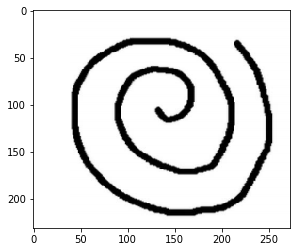

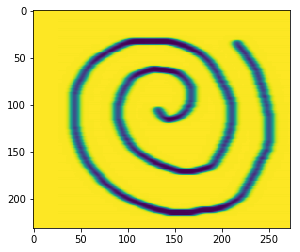

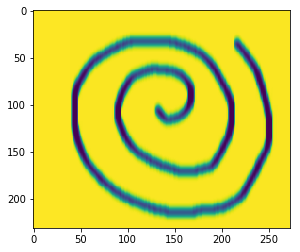

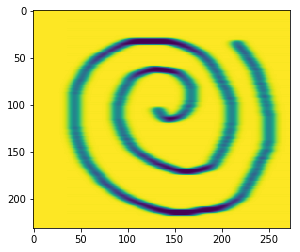

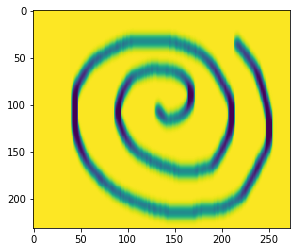

In [168]:
# IMAGE_DIR = "../Images/Unet_Images"
file_name = "../Images/testing.png"
image = cv2.imread(file_name)
# image = image[100:300, 100:300]
# image = cv2.GaussianBlur(image, (5, 5), 3.0)
# sobelX = cv2.Sobel(smooth_image, cv2.CV_64F, 2, 0, ksize = 5)
# sobelY = cv2.Sobel(smooth_image, cv2.CV_64F, 0, 2, ksize = 5)
# stacked_sobel = np.dstack([sobelX, sobelY])

fx = np.zeros((image.shape[0], image.shape[1]))
fy = np.zeros((image.shape[0], image.shape[1]))
for i in range(image.shape[0]):
    for channel in range(image.shape[2]):
        fx[i] += gaussian_filter1d(image[i, :, channel], sigma = 3)
for i in range(image.shape[1]):
    for channel in range(image.shape[2]):
        fy[:, i] += gaussian_filter1d(image[:, i, channel], sigma = 3)

deltaX = deepcopy(fx)
deltaY = deepcopy(fy)
for i in range(fx.shape[0]):
    deltaX[i] = gaussian_filter1d(fx[i], sigma = 3.5)
for i in range(fy.shape[1]):
    deltaY[:, i] = gaussian_filter1d(fy[:, i], sigma = 3.5)

stacked_sobel = np.dstack([deltaX, deltaY])

plt.imshow(image)
plt.show()
plt.imshow(fx)
plt.show()
plt.imshow(fy)
plt.show()
plt.imshow(deltaX)
plt.show()
plt.imshow(deltaY)
plt.show()
# plt.imshow(smooth_image)
# plt.show()
# plt.imshow(sobelX)
# plt.show()
# plt.imshow(sobelY)
# plt.show()

1.0
0.6711649306740795


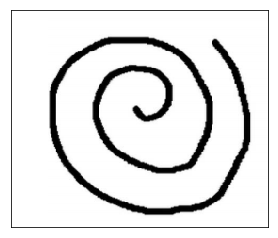

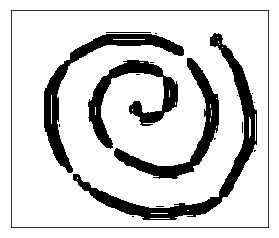

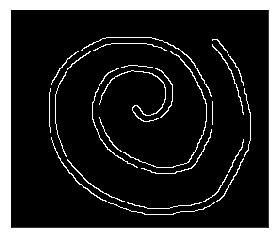

In [169]:
def zero_pad(image, ksize = 3):                                           
    padding = (ksize - 1) // 2
    padded_image = np.zeros((image.shape[0] + (padding*2), image.shape[1] + (padding*2), image.shape[2]))
    padded_image[padding:image.shape[0] + padding, padding:image.shape[1] + padding, ] = image
    return padded_image

def dsm(image, N = 9, threshold = 0.7): 
    padding = (N - 1) // 2
    dsm_matrix = np.zeros((image.shape[0], image.shape[1]))
    for i in range(padding, image.shape[0] - padding):
        for j in range(padding, image.shape[1] - padding):
            window = image[i - padding : i + padding + 1, j - padding : j + padding + 1]
            covariance_matrix = np.zeros((2, 2))
            for row in range(N):
                for column in range(N):
                    matrix = window[row, column].reshape(2, 1)
                    covariance_matrix += matrix @ matrix.T
            eigenvalues, _ = np.linalg.eigh(covariance_matrix)
            eigenvalues = np.sqrt(eigenvalues)
            value = eigenvalues[1] / sum(eigenvalues)
            if np.isnan(value):
                value = 0.5
            dsm_matrix[i, j] = value
    output = dsm_matrix[padding:dsm_matrix.shape[0] - padding, padding:dsm_matrix.shape[1] - padding, ]
    print(np.max(output))
    print(np.min(output))
    output = np.where(output >= threshold, 1, 0)
    return output

padded_sobel = zero_pad(stacked_sobel, ksize = 5)
dsm_output = dsm(stacked_sobel, N = 5, threshold = 0.96)

canny_output = cv2.Canny(image, 100, 200)

plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(dsm_output, cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(canny_output, cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.show()

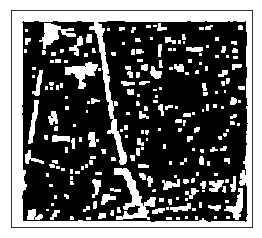

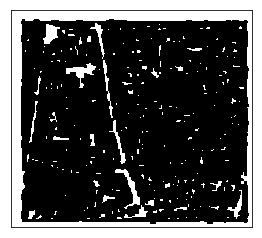

In [167]:
kernel_dil = np.ones((5, 5), np.uint8)
kernel_ero = np.ones((3, 3), np.uint8)
erode = cv2.erode(dsm_output.astype(np.uint8), kernel_ero, iterations = 1)
dilate = cv2.dilate(erode, kernel_dil, iterations = 1)
erode = cv2.erode(dilate, kernel_ero, iterations = 2)

plt.imshow(dilate, cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(erode, cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.show()